In [1]:
# library imports
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# helper function, generate lagged datasets for testing on vintages
def gen_lagged_data(metadata, data, last_date, lag):
    # only go up to the last date
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] # publication lag of this particular variable
        # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back), also -1 because 0 lag means in month, last month data available, not current month in
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# helper function, flatten a dataset for methods that don't do timeseries, extra columns for each lag
def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

# helper function fill missings in a dataset with the mean from the training set
def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [3]:
# data read
data = pd.read_csv("../data/data_tf.csv", parse_dates=["date"])
metadata = pd.read_csv("../data/meta_data.csv")

# target variable = GDP
target_variable = "gdpc1"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "1947-01-01"
test_start_date = "2005-03-01"
test_end_date = "2010-03-01"

# test dataset
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True)

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
data.tail()

,date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,...,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
908,2022-09-01,0.001761,0.008012,0.003860,0.002038,-0.134675,-0.001673,-0.054054,-0.028515,0.003825,...,-0.010373,0.005759,0.004644,0.003443,0.014267,0.002561,0.002485,0.005911,-0.009476,0.002056
909,2022-10-01,0.001856,NaN,0.004384,0.007362,0.082290,0.013066,0.057143,-0.021160,-0.000625,...,-0.004193,0.002715,0.002616,0.003729,-0.033248,-0.001789,0.002913,NaN,-0.003827,NaN
910,2022-11-01,0.001716,NaN,0.000963,-0.020892,0.057851,-0.005824,0.000000,-0.004881,-0.002195,...,-0.006316,0.001987,0.001681,0.001043,-0.106481,-0.003271,NaN,NaN,-0.002561,NaN
911,2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
912,2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training the model
The model is trained on a rolling basis. So if we are predicting 2000-03-01, the model is trained on data as it would have appeared in 1999-12-01, right before the beginning of the prediction period.

In [5]:
# this cell is form information only. The process is repeated below for each test date.
transformed_train = mean_fill_dataset(test, test) # fill any missing values with the mean
transformed_train = flatten_data(transformed_train, target_variable, 4) # 4 means include 4 additional lags of each variable
# only keep quarterly observations and drop early observations with not enough history for lagged variables
transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)

# we can see that e.g. the variable `payems` now has 4 columns in the data, for each of the lags, and that the data now has one row per quarter
transformed_train.loc[:, [True] + list(transformed_train.columns[1:].str.contains("payems"))].tail()

,date,payems,payems_1,payems_2,payems_3,payems_4
247,2009-03-01,-0.006001,-0.005543,-0.005814,-0.005209,-0.005335
248,2009-06-01,-0.003552,-0.002595,-0.005245,-0.006001,-0.005543
249,2009-09-01,-0.001847,-0.001400,-0.002595,-0.003552,-0.002595
250,2009-12-01,-0.002068,0.000092,-0.001528,-0.001847,-0.001400
251,2010-03-01,0.001396,-0.000709,0.000015,-0.002068,0.000092


# Testing the model on artificial data vintages

In [6]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [7]:
pred_dict = {k: [] for k in lags}
for date in dates:
    # preparing the data for the model
    train = test.loc[test.date <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10],:] # data as it would have appeared at beginning of prediction period
    transformed_train = mean_fill_dataset(train, train) # fill any missing values with the mean
    transformed_train = flatten_data(transformed_train, target_variable, 4) # 4 means include 4 additional lags of each variable
    # only keep quarterly observations and drop early observations with not enough history for lagged variables
    transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)
    
    # training the actual model
    model = Ridge(alpha = 0.1)
    x = transformed_train.drop(["date", target_variable], axis=1)
    y = transformed_train[target_variable]
    model.fit(x, y)
    
    for lag in lags:
        # the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag)

        # get data in format necessary for model
        tmp_data = mean_fill_dataset(train, tmp_data) # fill with the mean of the training set
        tmp_data = flatten_data(tmp_data, target_variable, 4)
        x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
        
        pred = model.predict(x)[0]
        pred_dict[lag].append(pred)

# Assess and visualize model performance

In [8]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = pd.concat([performance, tmp]).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE
0,-2,0.0082
1,-1,0.0062
2,0,0.0053
3,1,0.0050
4,2,0.0047


''

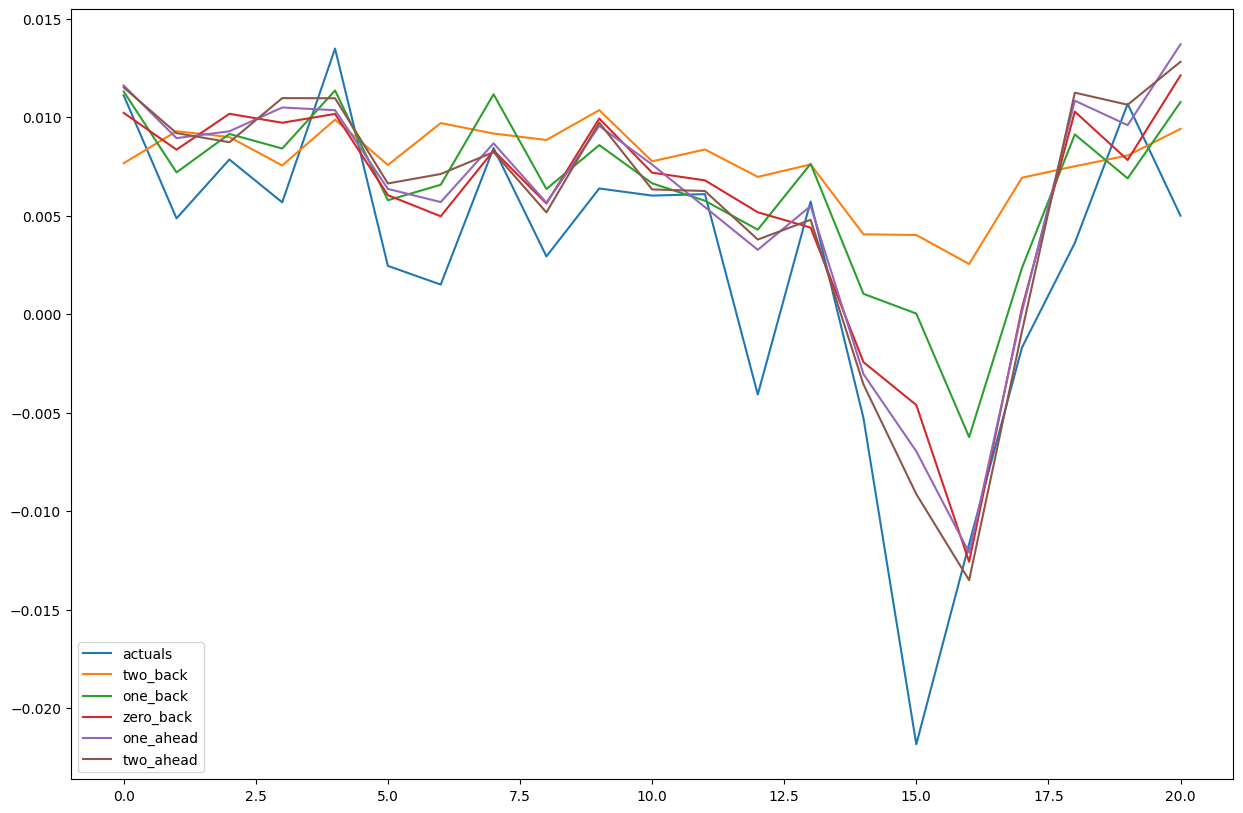

In [9]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [10]:
# the test data ends 2010-03-01, let's say we wanted to predict 2010-06-01
new_data = test.copy()

# the date we want predicted must be in the date, if it's not there it must be added
desired_date = pd.to_datetime("2010-06-01")

while desired_date > np.max(new_data.date):
    new_data.loc[len(new_data), "date"] = np.max(new_data.date) + pd.DateOffset(months=1)

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data.tail()

,date,payems,gdpc1,cpiaucsl,dgorder,hsn1f,rsafs,unrate,houst,indpro,...,ir,cpilfesl,pcepilfe,pcepi,permit,tcu,businv,ulcnfb,iq,a261rx1q020sbea
757,2010-02-01,-0.000709,NaN,-0.000952,-0.003127,-0.026087,0.002289,0.000000,-0.016287,0.003535,...,-0.000794,0.000444,0.000873,-0.000031,0.022013,0.005553,0.006595,NaN,-0.003314,NaN
758,2010-03-01,0.001396,0.005001,0.000331,0.009410,0.133929,0.021696,0.010204,0.052980,0.007105,...,0.003975,0.000236,0.001496,0.001416,0.056923,0.009229,0.004449,-0.01191,0.007481,0.005757
759,2010-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
760,2010-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
761,2010-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# now transform the data into the appropriate format for the model
transformed_new_data = mean_fill_dataset(new_data, new_data) # we can use the latest data for mean filling, since this isn't for model assessment but inference
transformed_new_data = flatten_data(transformed_new_data, target_variable, 4)

In [12]:
# obtain prediction for the new period
# drop all data but period we're interested in
new_x = transformed_new_data.loc[transformed_new_data.date == "2010-06-01", :].drop(["date", target_variable], axis=1)
model.predict(new_x)[0]

0.0078078579443364455